In [0]:
# 라이브러리 불러오기
import tensorflow as tf
import numpy as np

In [0]:
# 꽃 데이터 불러오기
from sklearn import datasets
iris = datasets.load_iris()

x_val = iris['data'][:, -1, None]
y_val = iris['data'][:, 0, None]

x_name = iris['feature_names'][-1]
y_name = iris['feature_names'][0]

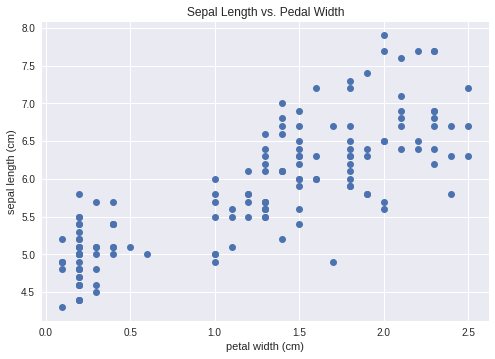

In [3]:
# 데이터 시각화
import matplotlib.pyplot as plt

plt.plot( x_val, y_val, 'o', label='Data' )
plt.title( 'Sepal Length vs. Pedal Width' )
plt.xlabel( x_name )
plt.ylabel(y_name)
plt.show()

In [0]:
# 학습 파라미터 정의

learning_rate = 0.05
batch_size = 25
epoch = 15



```
# This is formatted as code
```

## Step 1. Tensor 및 Variable 생성

$$
y=weight*x+bias
$$

x 와 y는 feeding이 필요한 tensor - tf.placeholder

Weight 와  bias는 Variable (또는 가변형 Tensor) - tf.Variable

In [5]:
# 입력 Tensor 생성 - Placeholder
x_data = tf.placeholder(shape=(None, 1), dtype=tf.float32)
y_target = tf.placeholder(shape=(None, 1), dtype=tf.float32)

# 변수 (Variable) 생성
with tf.variable_scope("variables", reuse=tf.AUTO_REUSE): # "variables" 라는 이름으로 Tensor들을 그룹 짓는다
    weight = tf.Variable(initial_value=tf.random_normal(shape=[1,1]), dtype=tf.float32, name="weight")
    bias = tf.get_variable(initializer=tf.random_normal(shape=[1]), dtype=tf.float32, name="bias")

# y_prediction = weight*x_data+bias
y_prediction = tf.matmul(x_data, weight)
y_prediction = tf.add(y_prediction, bias)

print(x_data)
print(y_target)
print(weight)
print(bias)
print(y_prediction)

Tensor("Placeholder:0", shape=(?, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
<tf.Variable 'variables/weight:0' shape=(1, 1) dtype=float32_ref>
<tf.Variable 'variables/bias:0' shape=(1,) dtype=float32_ref>
Tensor("Add:0", shape=(?, 1), dtype=float32)


## Step 2. Loss 및 Optimizer 생성

In [0]:
# Loss / Error 함수 정의 (L2 Loss)
loss = tf.square(y_target - y_prediction)
loss = tf.reduce_mean(loss)

In [0]:
# Optimizer 정의
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
update_operation = optimizer.minimize(loss)

## Step 3. Session 정의 및 학습 시작

![대체 텍스트](https://github.com/ku-milab/Neuroimage-Analysis-Tutorial/raw/master/data/operation.png)

In [0]:
# 세션 정의
sess = tf.Session()

# Variable 초기화 (weight, bias)
sess.run(tf.global_variables_initializer())

In [9]:
fetch_dict = {"loss": loss, "update": update_operation} # 출력 및 실행 할 Tensor
feed_dict = {x_data: None, y_target: None} # 입력 할 Tensor

loss_log = []

for current_epoch in range(epoch):
    # 임의의 데이터 선택
    random_index = np.random.permutation(len(x_val))
    for step in range(0, len(random_index), batch_size):
        current_index=random_index[step:step+batch_size]
        feed_dict.update({x_data: x_val[current_index], y_target: y_val[current_index]})
        
        ## fetch_dict의 모든 Tensor들을 실행 및 출력한다
        result = sess.run(fetch_dict, feed_dict=feed_dict)
        
        loss_log += [result["loss"]]
    if current_epoch%10 ==0:
        print(current_epoch, loss_log[-1])

0 4.189203
10 0.42920235


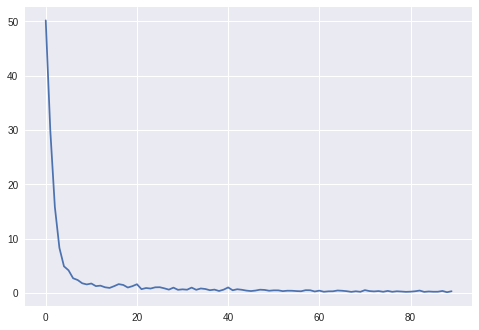

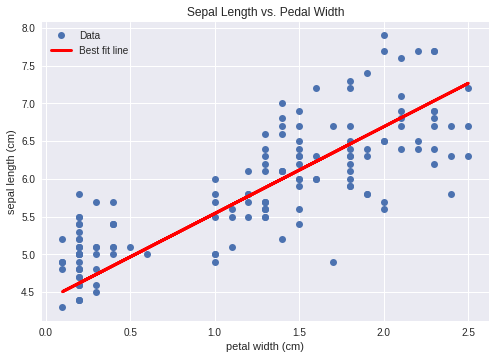

In [10]:
# Loss 그래프 시각화
plt.plot(loss_log)
plt.show()

# 데이터 시각화
W = sess.run(weight)
b = sess.run(bias)

best_fit = np.squeeze([W*x+b for x in x_val])


plt.plot( x_val, y_val, 'o', label='Data' )
plt.plot(x_val, best_fit, 'r-', label='Best fit line', linewidth=3 )
plt.legend( loc='upper left' )
plt.title( 'Sepal Length vs. Pedal Width' )
plt.xlabel( x_name )
plt.ylabel(y_name)
plt.show()

## Step 4. 모델 저장/불러오기 및 Tensorboard 시각화 

In [0]:
model_path = "./model/"
summary_path = "./log/"

!rm -rf ./log
!rm -rf ./model

# Tensorboard Summary
summary_writer = tf.summary.FileWriter(summary_path, graph=sess.graph)
summary_op = tf.summary.merge([
    tf.summary.scalar("loss", loss)
])

# Model Saver
saver = tf.train.Saver(max_to_keep=epoch)

In [12]:
# 모델 다시 초기화
sess.run(tf.global_variables_initializer())

fetch_dict = {"loss": loss, "update": update_operation, "summary": summary_op}
feed_dict = {x_data: None, y_target: None}

trn_cnt = 0
for current_epoch in range(epoch):
    random_index = np.random.permutation(len(x_val))
    for step in range(0, len(random_index), batch_size):
        current_index=random_index[step:step+batch_size]
        feed_dict.update({x_data: x_val[current_index], y_target: y_val[current_index]})
        
        result = sess.run(fetch_dict, feed_dict=feed_dict)
        
        # 각 step 마다 시각화
        summary_writer.add_summary(result["summary"], global_step=trn_cnt)
        
        trn_cnt +=1
    # 각 epoch 마다 모델 저장    
    saver.save(sess=sess, save_path=model_path+"%d.ckpt"%current_epoch)
    if current_epoch % 10 ==0:
        print("Checkpoint saved in %s"%model_path+"%d.ckpt"%current_epoch)

Checkpoint saved in ./model/0.ckpt
Checkpoint saved in ./model/10.ckpt


INFO:tensorflow:Restoring parameters from ./model/0.ckpt
INFO:tensorflow:Restoring parameters from ./model/3.ckpt
INFO:tensorflow:Restoring parameters from ./model/7.ckpt
INFO:tensorflow:Restoring parameters from ./model/10.ckpt
INFO:tensorflow:Restoring parameters from ./model/14.ckpt


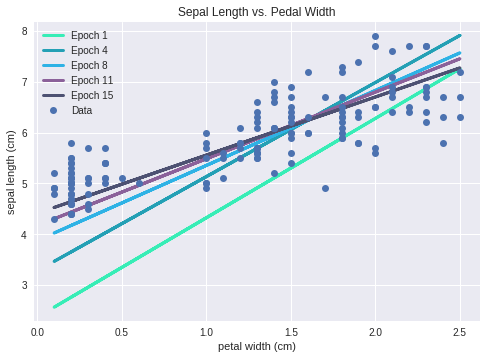

In [13]:
best_fit = []
for cnt in np.linspace(start=0, stop=epoch-1, num=5, dtype=np.uint16, endpoint=True):
    saver.restore(sess=sess, save_path=model_path+"%d.ckpt"%cnt)
    W, b = sess.run([weight, bias])
    best_fit = np.squeeze([W*x+b for x in x_val])
    plt.plot(x_val, best_fit, 'r-', label='Epoch %d'%(cnt+1), linewidth=3 , c=np.random.rand(3,))

plt.plot( x_val, y_val, 'o', label='Data' )
plt.legend( loc='upper left' )
plt.title( 'Sepal Length vs. Pedal Width' )
plt.xlabel( x_name )
plt.ylabel(y_name)

plt.show()

In [14]:
# Tensorboard 데모
!wget -nc https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py

import tboard
ROOT=%pwd
url = tboard.launch_tensorboard(bin_dir=ROOT, log_dir=summary_path)
print(url)

--2018-08-13 11:49:43--  https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘tboard.py’

tboard.py           100%[===================>]   5.09K  --.-KB/s    in 0s      

2018-08-13 11:49:43 (46.8 MB/s) - ‘tboard.py’ saved [5214/5214]

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= http://107d5b99.ngrok.io
http://107d5b99.ngrok.io
